PyImageJ Code Snippets
===

In this notebook we'll cover how to perform some common imagej operations (_i.e._ extracting channels, merging, etc..) in PyImageJ.

First let's intitalize ImageJ and load in a test stack (3-channel time series dataset).

In [1]:
import imagej
import scyjava as sj
import numpy as np
import xarray as xr

# start imagej and print the version number
ij = imagej.init()
ij.getVersion()

'2.2.0/1.53c'

## Opening and handling images from different sources
There are different steps to getting images into PyImageJ depending on the source. Here are a few common sources of images and how to get them into PyImageJ

**`ij.ij().open()`** Using ImageJ's opener

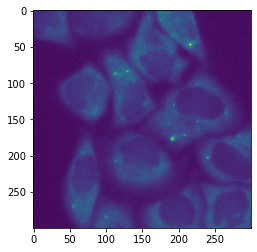

In [2]:
# open an image from local disk
img_ij_local = ij.io().open('sample-data/test_still.tif')
ij.py.show(img_ij_local)

[java.lang.Enum.toString] [INFO] Populating metadata


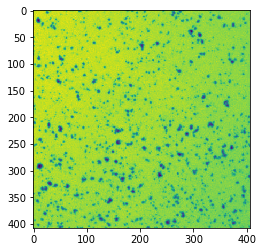

In [3]:
# open an image from the web
img_ij_web = ij.io().open('https://wsr.imagej.net/images/Cell_Colony.jpg')
ij.py.show(img_ij_web)

Note that `ij.io().open()` returns a `net.imagej.DefaultDataset`, an imagej java object.

In [4]:
# check image object type
print("img_ij_local type: {}".format(type(img_ij_local)))
print("img_ij_web type: {}".format(type(img_ij_web)))

img_ij_local type: <java class 'net.imagej.DefaultDataset'>
img_ij_web type: <java class 'net.imagej.DefaultDataset'>


**`io.imread()`** Using scikit-image's opener

In [5]:
# import io from scikit-image
from skimage import io

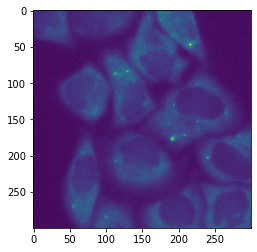

In [6]:
# open image from local disk
img_ski_local = io.imread('sample-data/test_still.tif')
ij.py.show(img_ski_local)

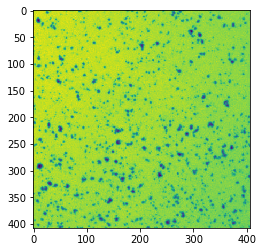

In [7]:
# open image from web
img_ski_web = io.imread('https://wsr.imagej.net/images/Cell_Colony.jpg')
ij.py.show(img_ski_web)

Unlike `ij.io().open()`, scikit-image's `io.imread()` returns a generic numpy array.

In [8]:
# check image object type
print("img_ski_local type: {}".format(type(img_ski_local)))
print("img_ski_web type: {}".format(type(img_ski_web)))

img_ski_local type: <class 'numpy.ndarray'>
img_ski_web type: <class 'numpy.ndarray'>


Numpy arrays can be converted into `net.imagej.DefaultDataset` java objects with the `to_dataset` method.

In [9]:
# convert numpy arrays to `DefaultDataset`
img_ski_local = ij.py.to_dataset(img_ski_local)
img_ski_web = ij.py.to_dataset(img_ski_web)

# check image object type
print("img_ski_local type: {}".format(type(img_ski_local)))
print("img_ski_web type: {}".format(type(img_ski_web)))

img_ski_local type: <java class 'net.imagej.DefaultDataset'>
img_ski_web type: <java class 'net.imagej.DefaultDataset'>


**`Image.open()`** Using PIL's (Python Image Library)

In [10]:
# import PIL
from PIL import Image

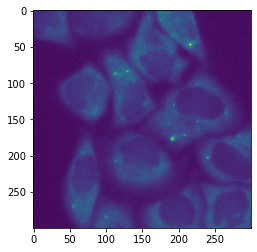

In [11]:
# open image from local disk
img_pil_local = Image.open('sample-data/test_still.tif')
ij.py.show(img_pil_local)

Opening web images with PIL is slightly more complicated. Here we use the package `requests` to get the image stream.

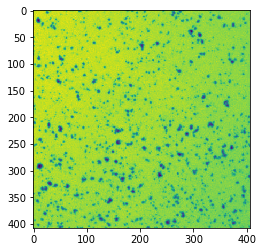

In [12]:
import requests

# open image from web
img_pil_web = Image.open(requests.get('https://wsr.imagej.net/images/Cell_Colony.jpg', stream=True).raw)
ij.py.show(img_pil_web)

With PIL objects are returned with their respective type relective the image format (_i.e._ opening a Tif file returns `PIL.TiffImagePlugin.TiffImageFile` type).

In [13]:
# check image object type
print("img_pil_local type: {}".format(type(img_pil_local)))
print("img_pil_web type: {}".format(type(img_pil_web)))

img_pil_local type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
img_pil_web type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


Directly calling `ij.py.to_dataset()` on these images will fail as PIL's object types are not supported. We can easily circumvent this by first converting to a genric numpy array.

In [14]:
# convert PIL images to np arrays
img_pil_local_np = np.array(img_pil_local)
img_pil_web_np = np.array(img_pil_local)

# check image object type
print("img_pil_local_np type: {}".format(type(img_pil_local_np)))
print("img_pil_web_np type: {}".format(type(img_pil_web_np)))

img_pil_local_np type: <class 'numpy.ndarray'>
img_pil_web_np type: <class 'numpy.ndarray'>


Although we have a generic numpy array, calling `ij.py.to_dataset()` on these arrays fails due to an unsported `dtype` (in this case `>u2`).

In [15]:
img_pil_local_ij = ij.py.to_dataset(img_pil_local_np)

NotImplementedError: Cannot convert dtype to ImgLib2 type yet: >u2

To resolve this, inspect the array and set the `dtype` to match. In this case the test images are 16-bit 

img_pil_local_np = img_pil_local_np.astype('uint16')
img_pil_web_np = img_pil_local_np.astype('uint16')

In [16]:
Now call `ij.py.to_dataset()`.

In [17]:
# convert np array to imagej dataset
img_pil_local_ij = ij.py.to_dataset(img_pil_local_np)
img_pil_web_ij = ij.py.to_dataset(img_pil_web_np)

# check image object type
print("img_pil_local_ij type: {}".format(type(img_pil_local_ij)))
print("img_pil_web_ij type: {}".format(type(img_pil_web_ij)))

img_pil_local_ij type: <java class 'net.imagej.DefaultDataset'>
img_pil_web_ij type: <java class 'net.imagej.DefaultDataset'>


## Extract channels

Channels can be extracted by slicing the `xarray` channel coordinate. Below is a simple method that simplifies this process. Here you just need to pass the stack and which channel you want extracted.

In [18]:
def extract_channel(stack, channel: int):
    channel_num = channel - 1

    if len(stack.dims) == 4:
        extract = stack[:,channel_num,:,:]
        print("Extracted channel {}.".format(str(channel)))
    elif len(stack.dims) == 3:
        extract = stack[:,:,channel_num]
    else:
        print("No channels found: {}".format(stack.dims))

    # re-attach the Channel coordinate with the Channel dimension
    extract = extract.expand_dims('Channel')
    extract = extract.rename("Channel " + str(channel))

    return extract

In [19]:
# open a multi-channel image
img = ij.io().open('sample-data/test_still_stack.tif')

# convert dataset to xarray
img_xarr = ij.py.from_java(img)

# extract each channel
img_ch1 = extract_channel(img_xarr, 1)
img_ch2 = extract_channel(img_xarr, 2)
img_ch3 = extract_channel(img_xarr, 3)

## Combine channels

Split channels can be merged by using `xarray.merge()`. Below we merge channel 1 and channel 3 and create a new xarray `Dataset`.

In [20]:
# combine channel 1 and 3
img_combo = xr.merge([img_ch1, img_ch3])

# print new xarray dataset
img_combo

<xarray.Dataset>
Dimensions:    (Channel: 2, x: 300, y: 300)
Coordinates:
  * Channel    (Channel) float64 0.0 2.0
  * x          (x) float64 0.0 0.325 0.65 0.975 1.3 ... 96.2 96.53 96.85 97.18
  * y          (y) float64 0.0 0.325 0.65 0.975 1.3 ... 96.2 96.53 96.85 97.18
Data variables:
    Channel 1  (Channel, y, x) float64 1.293e+03 1.254e+03 1.266e+03 ... nan nan
    Channel 3  (Channel, y, x) float64 nan nan nan ... 2.482e+04 2.418e+04